# **NEURAL DEPENDENCY PARSING PROJECT**



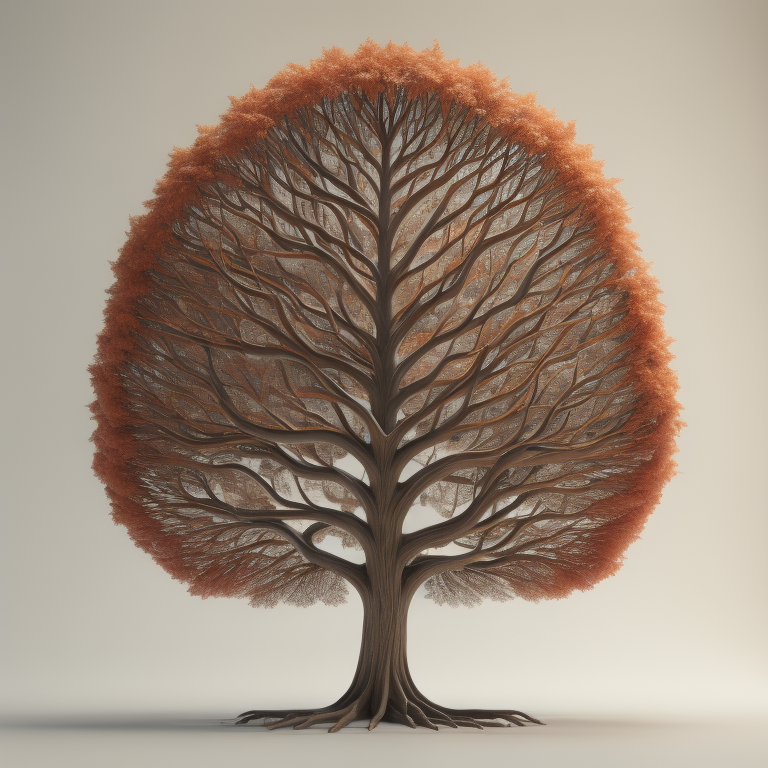


> **TEAM**:




*   **DIEGO ZANUTTI** -- 2061465: ***ICT for Internet & Multimedia***
*   **FRANCESCO PIVA** -- 2038151: ***Bioengineering for neurosience***





> # **Introduction**



Transition-based dependency parsing represents the most widespread syntactic representetation in natural language processing because it represents a good balance between:
*   linguistic expressivity;
*   annotation cost;
*   processing efficiency.

In this work, we use a modification of the standard parsing algorithm: the **arc-eager** model with the **static oracle.**  We augment the parser with neural machinery for *contextual word embeddings* and *attention word embeddings* and for choosing the most appropriate parser actions.

More in detail the steps are the following:


1.   Define Arc-egaer algorithm with static oracle;
2.   create a baseline model which uses **bi-LSTM** for extracting features from the input words;
3. use a second model (**BERT**) in place of bi-LSTM, and make comparisons
between two different versions of BERT: *multi-lingual cased BERT* and *Latin- BERT*;
4. models comparison with the SoTA.
5. conclusions.


In both cases (baseline model and BERT), training has been done under the static oracle and next transition classification is performed using MLP based on two top-most stack tokens and first token in the buffer. Unlike the arc-standard where that configuration it's always present, arc-eager can works also with only one element in the stack and in the buffer. Thus we have to take into account some limited cases.

Arc labels in dependency trees have been discarded, therefore **un-labelled attachment score (UAS)** has been used for the evaluation and models comparison.



> ## **Libraries and packages install**



In [ ]:
!pip install datasets
!pip install conllu

!pip install transformers

In [ ]:
# Installing the latin bert library
!wget https://github.com/andbue/latin-bert-huggingface/archive/master.zip

!unzip /content/master.zip
!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti" -O latin_bert.tar && rm -f /tmp/cookies.txt
!tar -xf latin_bert.tar --strip-components 1 -C ./latin-bert-huggingface-main/bert-base-latin-uncased
!rm latin_bert.tar

In [ ]:
# latin BERT model does not have specified the prefix for the sub-tokenized word, so we are adding ' ## ' as prefix
import json
with open("./latin-bert-huggingface-main/bert-base-latin-uncased/tokenizer.json", "r+") as jsonFile:
    data = json.load(jsonFile)
    data["model"]["continuing_subword_prefix"] = "##"

with open("./latin-bert-huggingface-main/bert-base-latin-uncased/tokenizer.json", "w") as jsonFile:
  json.dump(data, jsonFile, sort_keys=True, indent=4, separators=(',', ': '))


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from functools import partial
from datasets import load_dataset
from torch.optim.lr_scheduler import ExponentialLR
from transformers import AutoTokenizer, AutoModel

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [ ]:
# set seed
torch.manual_seed(0)



> # **Dataset**



The Universal Dependencies version of the **LLCT** (*Late Latin Charter Treebank*) results from an automated conversion of the LLCT2 treebank from the Latin Dependency Treebank (LDT) format into the Universal Dependencies standard. The LLCT2 is the second part of three LLCT treebanks (LLCT treebank contains three parts).


The LLCT2 contains **521 Early Medieval Latin original documents** (charters) written in Tuscia (Tuscany), Italy, between *AD 774* and *897*. Note that ***charters*** means private and semi-public documents. Their language is a non-standard variety of Latin which differs from Classical as well as from Medieval Latin in terms of spelling, morphology, and syntax.

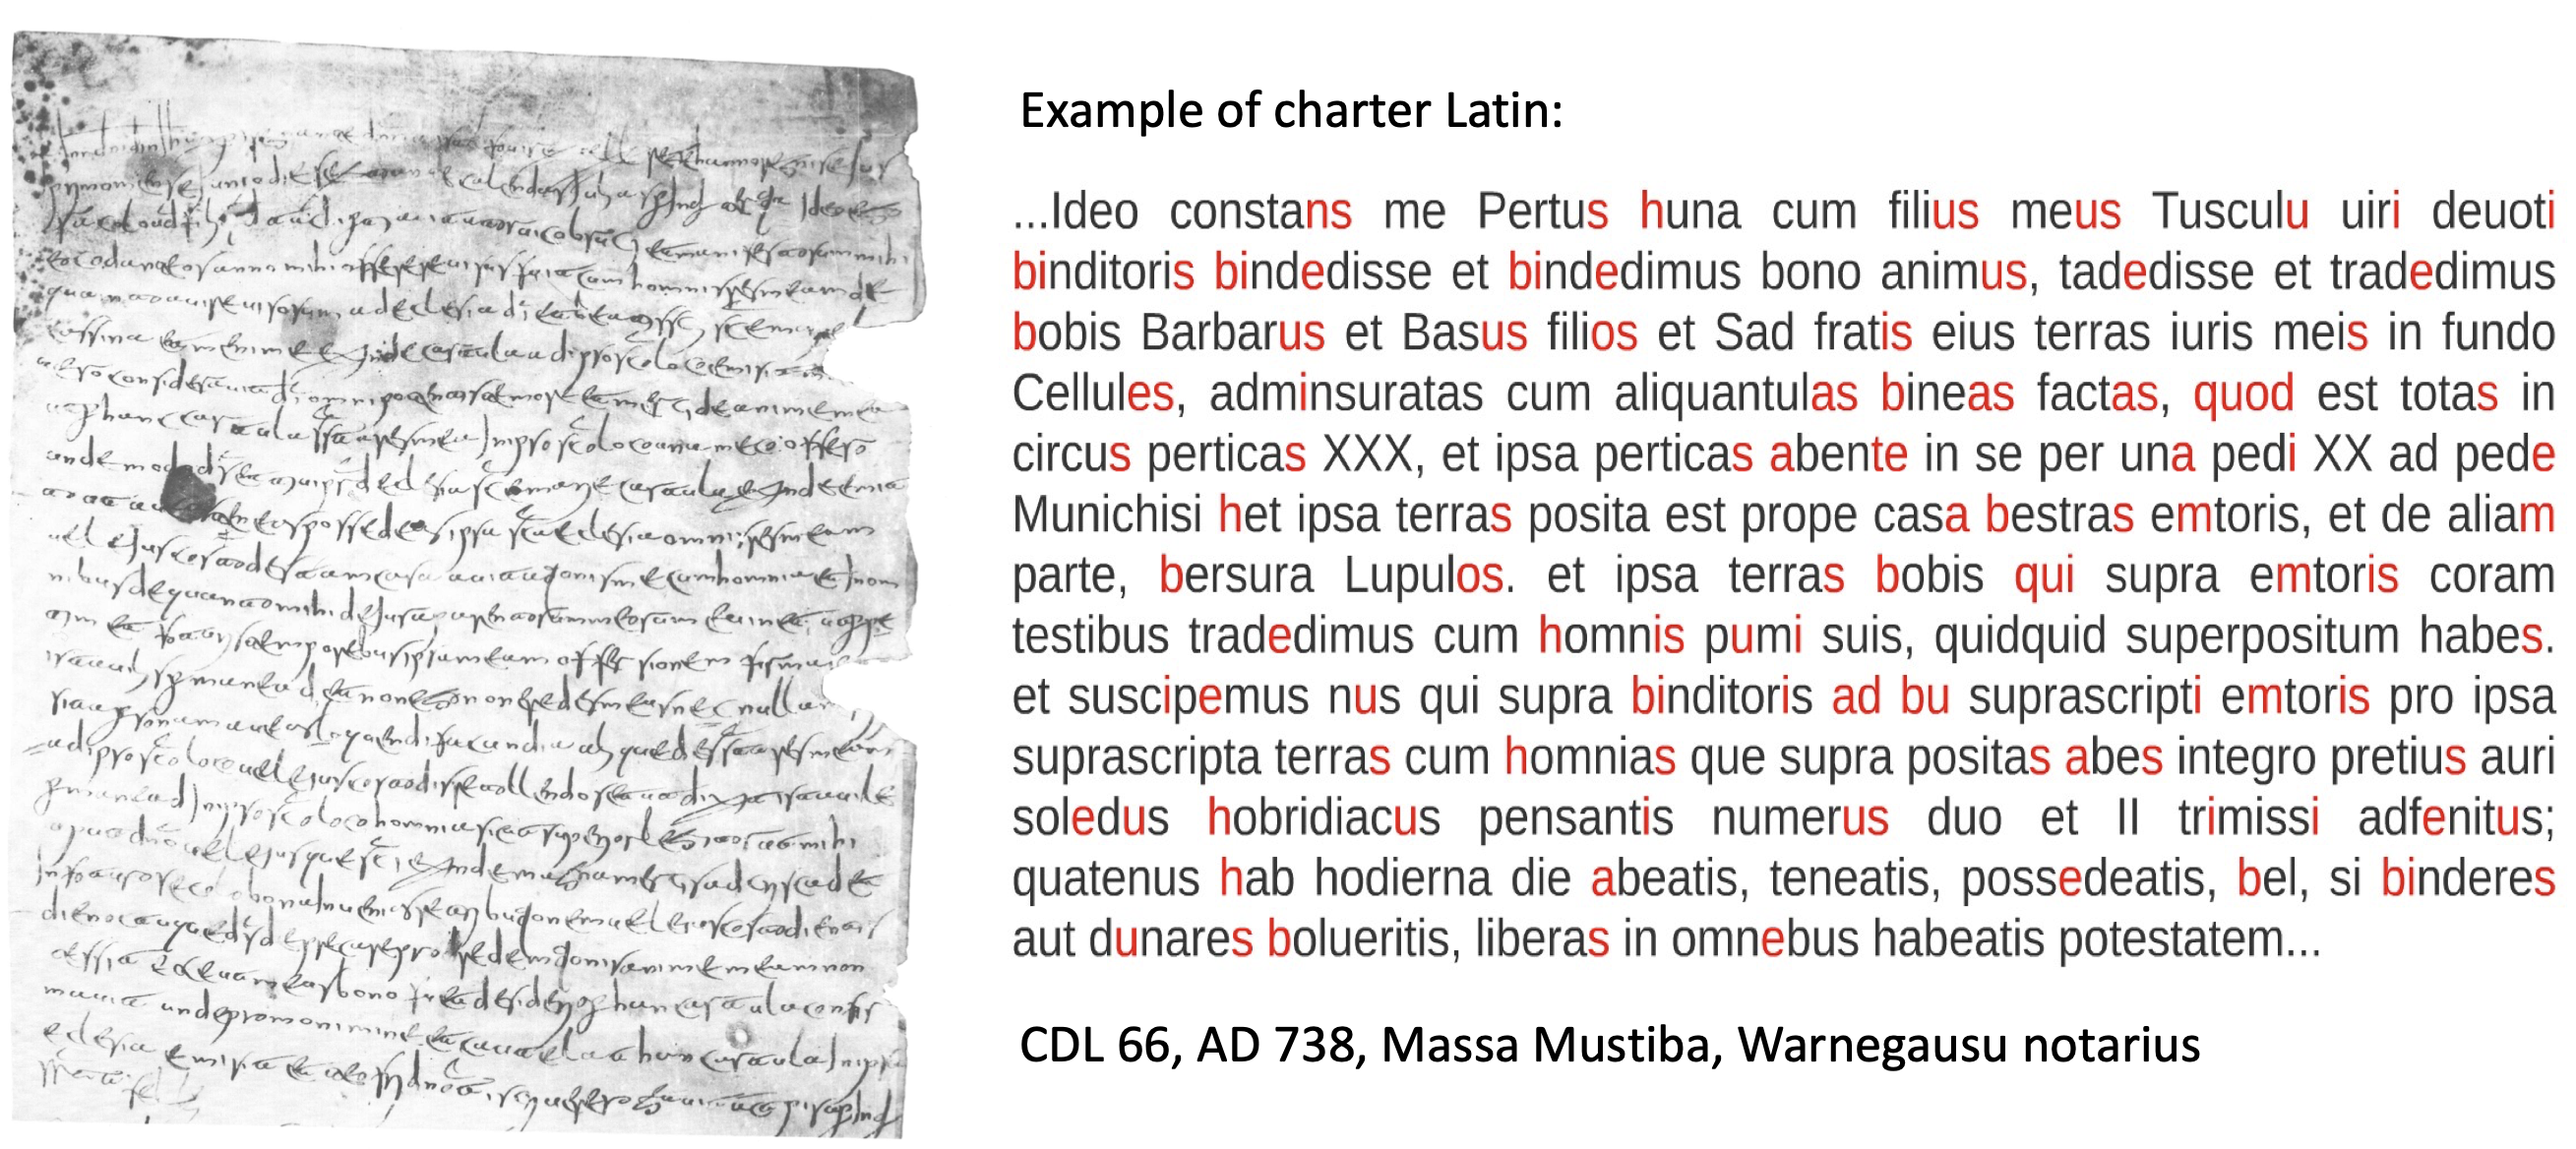

## **Choice motivation**

The choice of the Late Latin Charter Treebank (LLCT) dataset is motivated by several factors:

*   Applying language technologies for historical and ancient languages is an expanding field and is currently in active development. Also, latin is a language rich of information and a vast collection of texts available for analysis.
*  there is a gap in existing literature: while previous studies have used BERT on latin datasets such as ITTB or PROIEL from version precedent to v2.6 of Universal Dependencies, the introduction of LLCT in the UD v2.6, in 2020, means that the state of the art for this dataset is still relatively underdeveloped. Although there have been tests conducted on LLCT, they do not utilize BERT for extracting word embeddings. This gap in the literature motivates us to explore a novel approach to the task, which is currently not extensively documented. The state-of-the-art paper we found, which suggest the use of LatinBERT for LLCT to improve accuracy, serves as additional motivation for us to attempt a new approach to the task. This paper highlights the potential benefits of leveraging LatinBERT and encourages further investigation and experimentation in this domain, which is still relatively underexplored.





In [ ]:
# Downlaod dataset

print('Dowload dataset...')
train_dataset = load_dataset('universal_dependencies', 'la_llct', split="train")
val_dataset = load_dataset('universal_dependencies', 'la_llct', split="validation")
test_dataset = load_dataset('universal_dependencies', 'la_llct', split="test")


> ## **Statistics of UD Latin LLCT**



In [ ]:
#General statistics

print("Number of samples:")
print("Training set:\t \033[1m%d\033[0m" % len(train_dataset))
print("Validation set:\t \033[1m%d\033[0m" % len(val_dataset))
print("Test set:\t \033[1m%d\033[0m" % len(test_dataset))
print("\n")
print("Total number of sentences:\t\033[1m%d\033[0m" % (len(train_dataset) + len(val_dataset) + len(test_dataset)))

Number of samples:
Training set:	 7289
Validation set:	 850
Test set:	 884


Total number of sentences:	9023


### **Types vs. Tokens**


In [ ]:
def counter(train_dataset, val_dataset, test_dataset, flag = True):

  types_list = []
  tokens_list = []

  for dataset in [train_dataset, val_dataset, test_dataset]:
    for sample in dataset:
      for word in sample['tokens']:
        if word not in types_list:
          types_list.append(word)

        tokens_list.append(word)
  n_types = len(types_list)
  n_tokens = len(tokens_list)

  return n_types, n_tokens

In [ ]:
n_types, n_tokens = counter(train_dataset, val_dataset, test_dataset)
print('The size of the vocabulary is: ', n_types)
print('The number of tokens in the dataset is: ', n_tokens)

The size of the vocabulary is:  9414
The number of tokens in the dataset is:  242411


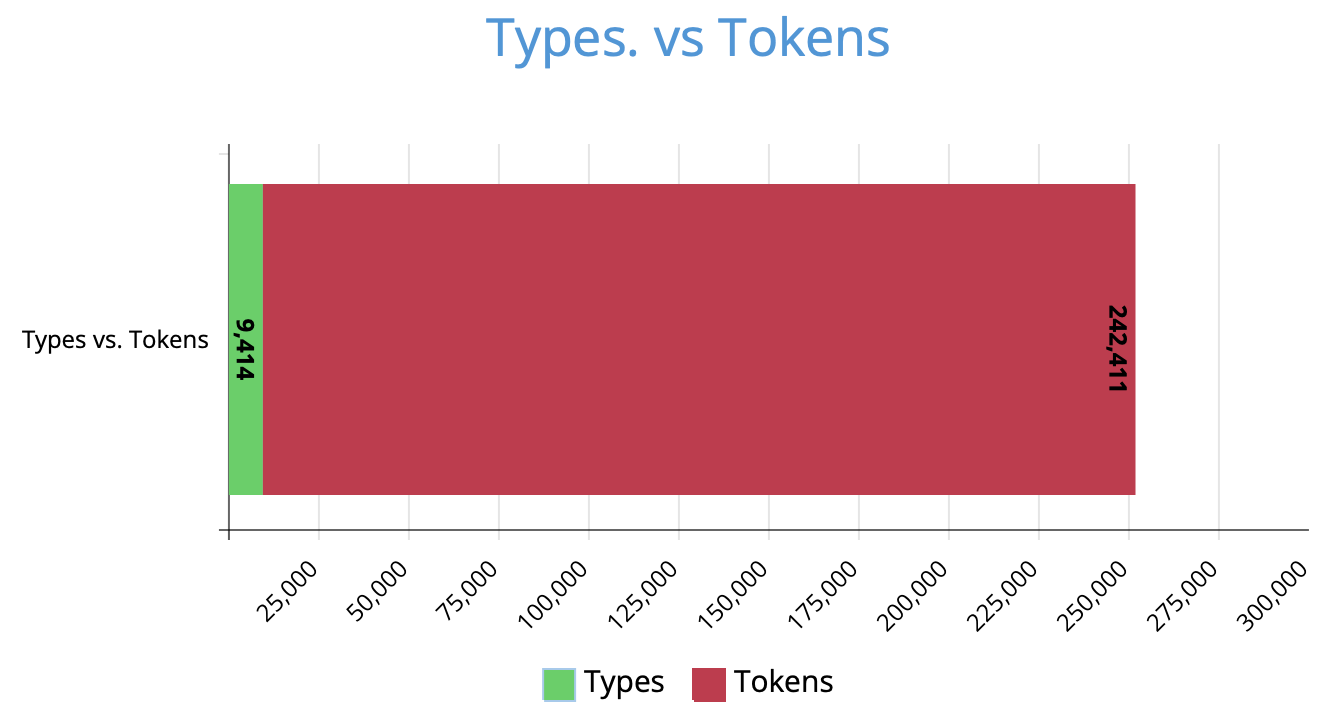

_____________________________________________________________________________

**Note that following analyses have been done only on the training set**

_____________________________________________________________________________

### **Projective vs. non-projective**

First of all, we want to give some insights about how many projective and non-projective tree contains our data-set. This is important because, so as to make our arc-eager system sound and complete, **we take into account only sentences that has projective tree-like syntactic structure**. Remember that a tree is said to be projecive if all the arcs are projective (the more rigorous definition of projectivity will be provided later).

In [ ]:
# Function that defines is a sentence is projective or not

def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

In [ ]:
train_dataset_projective = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]

In [ ]:
print('Number of projective sentences in the training set:',len(train_dataset_projective))
print('Number of non-projective sentences in the training set:',len(train_dataset)-len(train_dataset_projective))

Number of projective sentences in the training set: 5175
Number of non-projective sentences in the training set: 2114


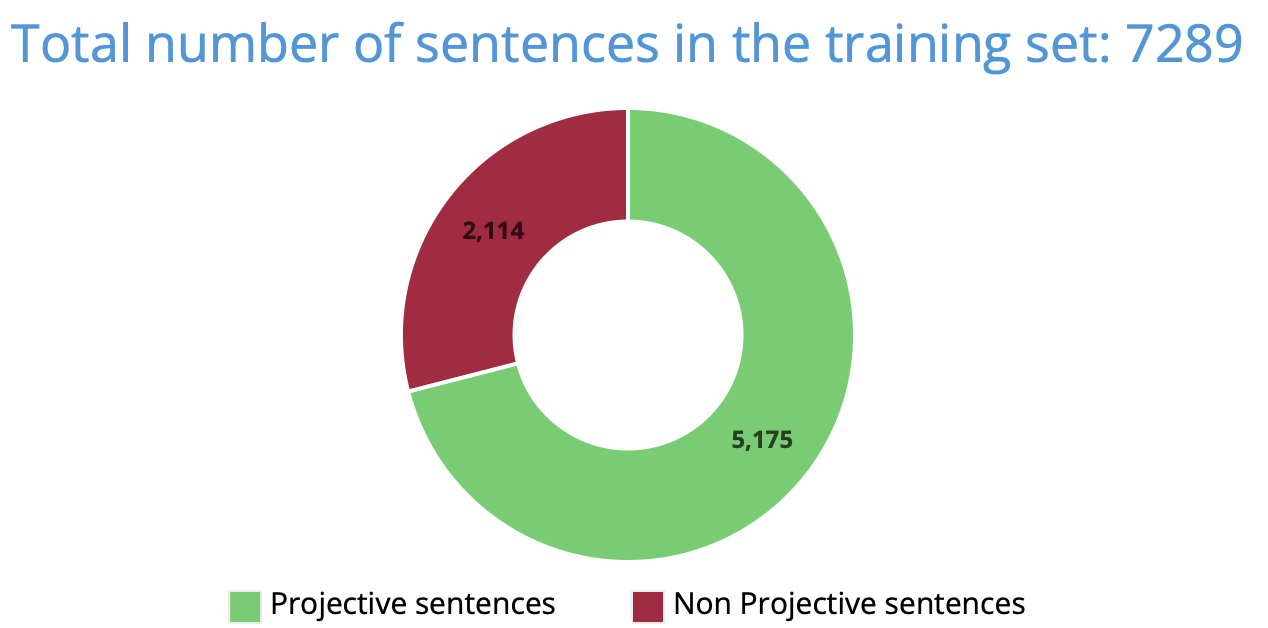

Considering the distribution of the training dataset, which consists of approximately 75% projective sentences and 25% non-projective sentences, it is reasonable to focus only on the projective sentences.

### **Sentences length distribution**

In [ ]:
def sentences_length(train_dataset, train_dataset_projective):
  sentences_length = []
  sentences_length_projective = []

  for sample in train_dataset:
      sentence_tokens = sample['tokens']
      sentences_length.append(len(sentence_tokens))

  for sample in train_dataset_projective:
      sentence_tokens = sample['tokens']
      sentences_length_projective.append(len(sentence_tokens))

  # Histogram 1 - sentences_length
  plt.hist(sentences_length, bins=100, edgecolor='black', color='#B22222', label='sentences length distribution')

  # Histogram 2 - sentences_length_projective
  plt.hist(sentences_length_projective, bins=50, edgecolor='black',color='#8FBC8F', label='sentences length distribution (only projective)')
  plt.title("Sentences length distribution")
  plt.xlabel("Sentences length")
  plt.ylabel("Number of sentences")
  plt.legend()
  plt.xlim(0, 150)


  # Mostra il grafico
  plt.show()

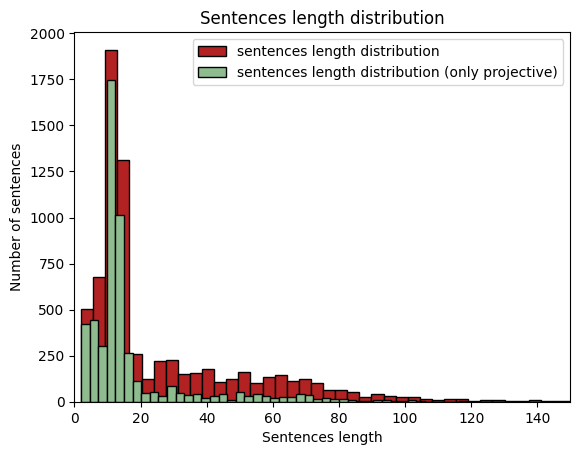

In [ ]:
sentences_length(train_dataset, train_dataset_projective)

Looking at the histogram above, it is evident that the exclusion of non-projective sentences does not significantly alter the distribution of sentence lengths.



> # **Arc-eager algorithm**



The configuration of the arc-eager parser is a triple of the form  (𝜎,𝛽,𝐴)  where:

*   𝜎  is the stack;
*   𝛽  is the input buffer;
*   𝐴  is a set of arcs constructed so far.

We write  𝜎𝑖 ,  𝑖≥1 , for the  𝑖 -th token in the stack; we also write  𝛽𝑖 ,  𝑖≥1 , for the  𝑖 -th token in the buffer.


The parser can perform **four** types of actions (transitions):


*   **shift:** as in arc-standard, it removes  𝛽1  from the buffer and pushes it into the stack;
*   **leftArc:** which creates the arc  (𝛽1→𝜎1) , and removes 𝜎1 from the stack;
*   **rightArc:** which creates the arc  (𝜎1→𝛽1) , and shift 𝛽1 into the stack;
*  **reduce**: pop the stack (so remove 𝛽1 from the stack).

### **Parser**

In [ ]:
class ArcEager:
  def __init__(self, sentence):

    #initial configuration
    self.sentence = sentence

    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = [] # create an empty stack
    self.arcs = [-1 for _ in range(len(self.sentence))] # arc setted to -1 as default

    # Stack initialization
    self.shift()

  #moves definition (shit - left_arc - right_arc - reduce)
  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def left_arc(self):
    head = self.buffer[0]
    dependent = self.stack.pop()

    if (dependent!=0) and (self.arcs[dependent]==-1):
      self.arcs[dependent] = head
    else:
      self.stack.append(dependent)

  def right_arc(self):
    head = self.stack[-1]
    dependent = self.buffer.pop(0)

    self.arcs[dependent] = head
    self.stack.append(dependent)

  def reduce(self):
    topmost = self.stack.pop()
    if (self.arcs[topmost]==-1):
      self.stack.append(topmost)


  def is_tree_final(self):
    return len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    stack = self.stack
    buffer = self.buffer


### **Oracle**

Parser is non-deterministic, which means that given a configuration, there is no unique action to reach the solution, but several actions are possible. Indeed remember that each sentence can have several syntactic structures, but only one is meaningful for that sentence. Therefore, in order to make parser **deterministic**, we use an **oracle** that guides the parser to take the correct transition at each iteration.
In other words, given a parser with a sentence and its gold tree, the oracle says which is the next move to reach our gold solution.

On this work, we use **static** oracle, even if it has some limitations, so sometimes dynamic version is preferred.

The oracle used in this notebook, for the arc-eager parser, works for every sentence which dependency tree is projective. It is based on the following conditions:
* If the set of gold arcs $A_{gold}$ contains the arc $(j,i)$ for the configuration $c = (σ|i, j|β, A)$ return the correct transition left_arc.
* If the set of gold arcs $A_{gold}$ contains the arc $(i,j)$ for the configuration $c = (σ|i, j|β, A)$ return the correct transition right_arc.
* For the configuration $c = (σ|i, j|β, A)$, if exists $k<i$ such that $A_{gold}$ contains the arc $(k,j)$ or $(j,k)$, meaning that there is an arc in the gold set between the leftmost token in the buffer and a token in the stack, left alone the topmost token, then return the reduce transition.
* If any other condition is not satisfied then return the shift transition.

In [ ]:
class EagerOracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    o1 = self.parser.buffer[0]
    o2 = self.parser.stack[len(self.parser.stack)-1]

    if self.gold[o2] == o1:
      return True

    return False

  def is_right_arc_gold(self):
    o1 = self.parser.buffer[0]
    o2 = self.parser.stack[-1]

    if self.gold[o1] != o2:
      return False

    return True

  def is_reduce_gold(self):
    topmost =  self.parser.stack[-1]
    reduce = False
    next = self.parser.buffer[0]
    if self.parser.arcs[topmost] != -1:
        reduce = True in ((self.gold[next] == k or self.gold[k] == next) for k in self.parser.stack[:-1])
    return reduce

  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False

    return True

  def apply_oracle(self):
    parser.print_configuration()

    while not parser.is_tree_final():

      if oracle.is_shift_gold():
        parser.shift()
      elif oracle.is_left_arc_gold():
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
      elif oracle.is_reduce_gold():
        parser.reduce()

    if parser.arcs == self.gold:
      pass
    else:
      print('\033[1mOracle provide wrong solution\033[0m')

  def print_next_move(self):

    if parser.is_tree_final():
        print("No more moves")
        return

    if oracle.is_left_arc_gold():
        print("Left Arc")
    elif oracle.is_right_arc_gold():
        print("Right Arc")
    elif oracle.is_reduce_gold():
        print("Reduce")
    else:
        print("Shift")

### **Test the oracle on the training set**

Now we want to test our oracle on our data-set. As is possible to observe, it works correctly

In [ ]:
from tqdm import tqdm
for sample in tqdm(list(train_dataset)):
  sentence_new = ['<ROOT>'] + sample['tokens']
  gold = [-1] + [int(idx) for idx in sample['head']]

  if is_projective(gold):
    parser = ArcEager(sentence_new)
    oracle = EagerOracle(parser, gold)
    oracle.apply_oracle()
  else:
    continue

100%|██████████| 7289/7289 [00:00<00:00, 8935.50it/s]




> # **Baseline model: bi-LSTM**



The first model that we used as **baseline-model** is the bi-LSTM. It works as follow:
1.   The model computes static word-embeddings;
2.   These embedding are transformed into contextual embeddings through the bi-LSTM layer, which looks left to right and right to left with respect to the word-embedding for the first word in the stack;
3.   Each contextual embedding is concatenated in groups of three and associated to a specific configuration;
4. Each configuration is passed through the FFNN which returns a score for each transition;
5. A *softmax* activation function is implemented to select the best transition.



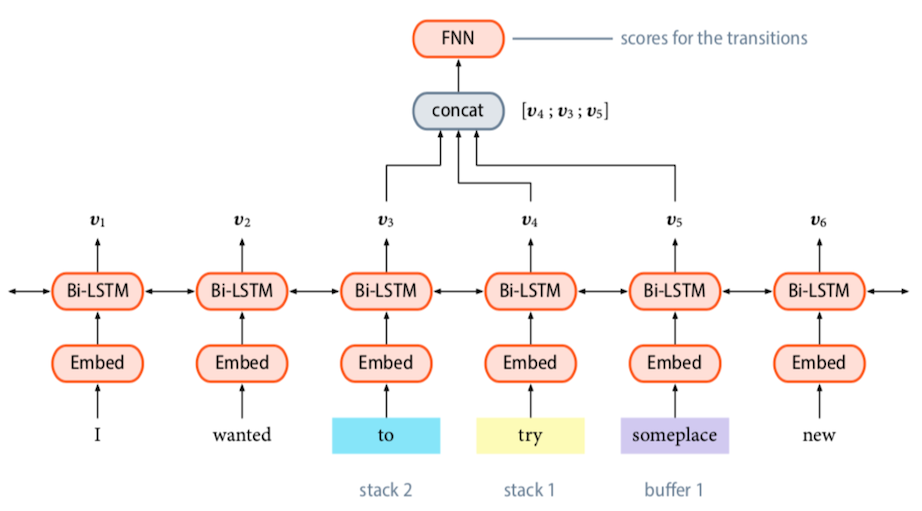

## **Create training data and iterable dataloaders**



This function generates a dictionary called "**MAP**" consisting of word/index pairs. This dictionary will be used later when word embeddings are created. Only words that appear at least three times are included in the dictionary. Each word (key) is assigned a unique value for identification. The threshold specifies the minimum frequency required for a token to be considered for inclusion in the embedding list.

In [ ]:
def create_dict(train_dataset, threshold=3):
  dic = {}  # dictionary of word counts

  for sample in train_dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 # Words that have less than three occurrences are not encoded and will later be mapped to special token <unk>.

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

On this project, we further restrict our attention to dependency trees that are **projective**, that is, where the presence of an arc $(i, l, j)$ entails that there is directed path from $i$ to every node $k$ such that $\min(i, j) < k < max(i, j)$. So, now we are creating our training set, validation set and test set by removing non-projective trees.

Afterwards, we apply the previously defined *create_dict* function, which assigns a unique index to each word in every sentence of the training set.

In [ ]:
# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
val_dataset = [sample for sample in val_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
test_dataset = [sample for sample in test_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]

# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)


print("Number of samples:")
print("Train:\t", len(train_dataset))
print("Val:\t", len(val_dataset))
print("Test:\t", len(test_dataset))

Number of samples:
Train:	 5175
Val:	 579
Test:	 665


The next function is used to process our data and create the actual training samples. In order to train the classifier, we need to convert the gold trees in our treebank into several pairs of the form configuration/gold action. This is what we do now.

For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree.  We then pair configurations and canonical actions.  Since our neural classifier will look only into $\sigma_1$, $\sigma_2$ and $\beta_1$, we do not have to record the full parser configuration. Recall that this is the standard case: arc-eager oracle works differently from arc-standard (see introduction).

In [ ]:
def process_sample_eager(sample, get_gold_path = False):

  sentence = ["<ROOT>"] + sample["tokens"]

  gold = [-1] + [int(i) for i in sample["head"]]

  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift, 3 reduce

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = EagerOracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)


      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()

      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)

      #new
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(2)

      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)


  return enc_sentence, gold_path, gold_moves, gold

Next function used to batch the training data.

In [ ]:
def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample_eager(s, get_gold_path=get_gold_path) for s in batch_data]

  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

Finally, we create dataloaders for train, development and test sets.

In [ ]:
BATCH_SIZE = 16

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, get_gold_path=True))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

## Create neural network model

We are now ready to train our parser on the dataset.  We start with the definition of some parameters. The choice on these parameters is done by manually performing a grid search, with a focus on the **learning rate**, which value is fundamental to obtain valid results.


In [ ]:
EMBEDDING_SIZE = 100
LSTM_SIZE = 300
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.1
EPOCHS = 20
LR = 1e-4 # learning rate

Next, we proceed to create our model. It comprises a bi-LSTM that represents words in conjunction with their contexts, and a feedforward network responsible for predicting the parser's next move."

Within the *parse_step()* method of the Net class, we select and execute the subsequent move based on the obtained scores. However, since these scores may indicate an action that cannot be legally performed, we need to redirect the parser to a valid action. This redirection can be achieved deterministically by selecting the only legal action or probabilistically by considering the second or third choice of the network based on the scores.

To prevent the parser from entering an infinite loop, we ensure that every possible configuration is covered, except for the final tree. This is accomplished through a series of conditions within the *parse_step() *method."

In [ ]:
class Net_eager(nn.Module):

  def __init__(self, device):
    super(Net_eager, self).__init__()
    self.device = device #device initialization
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)

  def forward(self, x, paths):

    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):
    parsers = [ArcEager(i) for i in x] #one parser for each sentence
    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]
    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)

      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[-1], parser.buffer[0]]
        if len(parser.stack) < 2:
          if len(parser.buffer) > 1:
            conf.append(parser.buffer[1])
          else:
            conf.append(-1)
        else:
          conf.insert(0,parser.stack[-2])
      configurations.append([conf])
    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly

  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    moves_topk = moves.topk(4).indices
    moves_second = moves_topk[:,1]

    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        p = -1;
        if i == p:
          print(parsers[i].buffer)
          print(parsers[i].stack)
        if moves_argm[i] == 0:
          if parsers[i].stack[-1] != 0:
            if parsers[i].arcs[parsers[i].stack[-1]] == -1:
              parsers[i].left_arc()
              if i == p: print("lx0")
            else:
              if moves_second[i] == 1:
                if len(parsers[i].buffer) >1:
                  parsers[i].right_arc()
                  if i == p: print("rx0")
                else:
                  if all(x != -1 for x in [parsers[i].arcs[ele] for ele in parsers[i].stack[1:]]):
                    parsers[i].right_arc()
                    if i == p: print("rx1")
                  else:
                    parsers[i].reduce()
                    if i == p: print("re0")
              else: #ambiguity between shift and reduce, shift has precedence
                if len(parsers[i].buffer) >1:
                  parsers[i].shift()
                  if i == p: print("s0")
                else:
                  parsers[i].reduce()
                  if i == p: print("re01")

          else:
            if moves_second[i] == 1:
              parsers[i].right_arc()
              if i == p: print("rx0")

            else:
              if len(parsers[i].buffer) <2:
                parsers[i].right_arc()
                if i == p: print("s0")
              else:
                parsers[i].shift()

        elif moves_argm[i] == 1:
          if len(parsers[i].buffer) > 1:
            parsers[i].right_arc()
            if i == p: print("rx2")
          else:
            if all(x != -1 for x in [parsers[i].arcs[ele] for ele in parsers[i].stack[1:]]):
              parsers[i].right_arc()
              if i == p: print("rx2")
            else:
              if parsers[i].stack[-1] != 0:
                if parsers[i].arcs[parsers[i].stack[-1]] == -1:
                  parsers[i].left_arc()
                  if i == p: print("lx0")
                else:
                  parsers[i].reduce()
                  if i == p: print("re0")

        elif moves_argm[i] == 2:
          if parsers[i].arcs[parsers[i].stack[-1]] != -1:
            parsers[i].reduce()
            if i == p: print("re2")
          else:
            if moves_second[i] == 0:
              if parsers[i].stack[-1] != 0:
                parsers[i].left_arc()
                if i == p: print("l3")
              else:
                if moves_topk[i,2] == 1 or len(parsers[i].buffer) < 2 :
                  parsers[i].right_arc()
                  if i == p: print("rx4")
                else:
                  parsers[i].shift()
                  if i == p: print("s2")
            elif moves_second[i] == 1:
              parsers[i].right_arc()
              if i == p: print("rx5")
            else:
              parsers[i].shift()
              if i == p: print("s3")

        elif moves_argm[i] == 3:
          if len(parsers[i].buffer) > 1:
            parsers[i].shift()
            if i == p: print("s5")
          else:
            if all(x != -1 for x in [parsers[i].arcs[ele] for ele in parsers[i].stack[1:]]):
                parsers[i].right_arc()
                if i == p: print("l4")
            else:
              if parsers[i].arcs[parsers[i].stack[-1]] != -1:
                parsers[i].reduce()
                if i == p: print("l5")
              else:
                parsers[i].left_arc()
                if i == p: print("rx6")

Schematical representation of different transition choice for every possible configuration

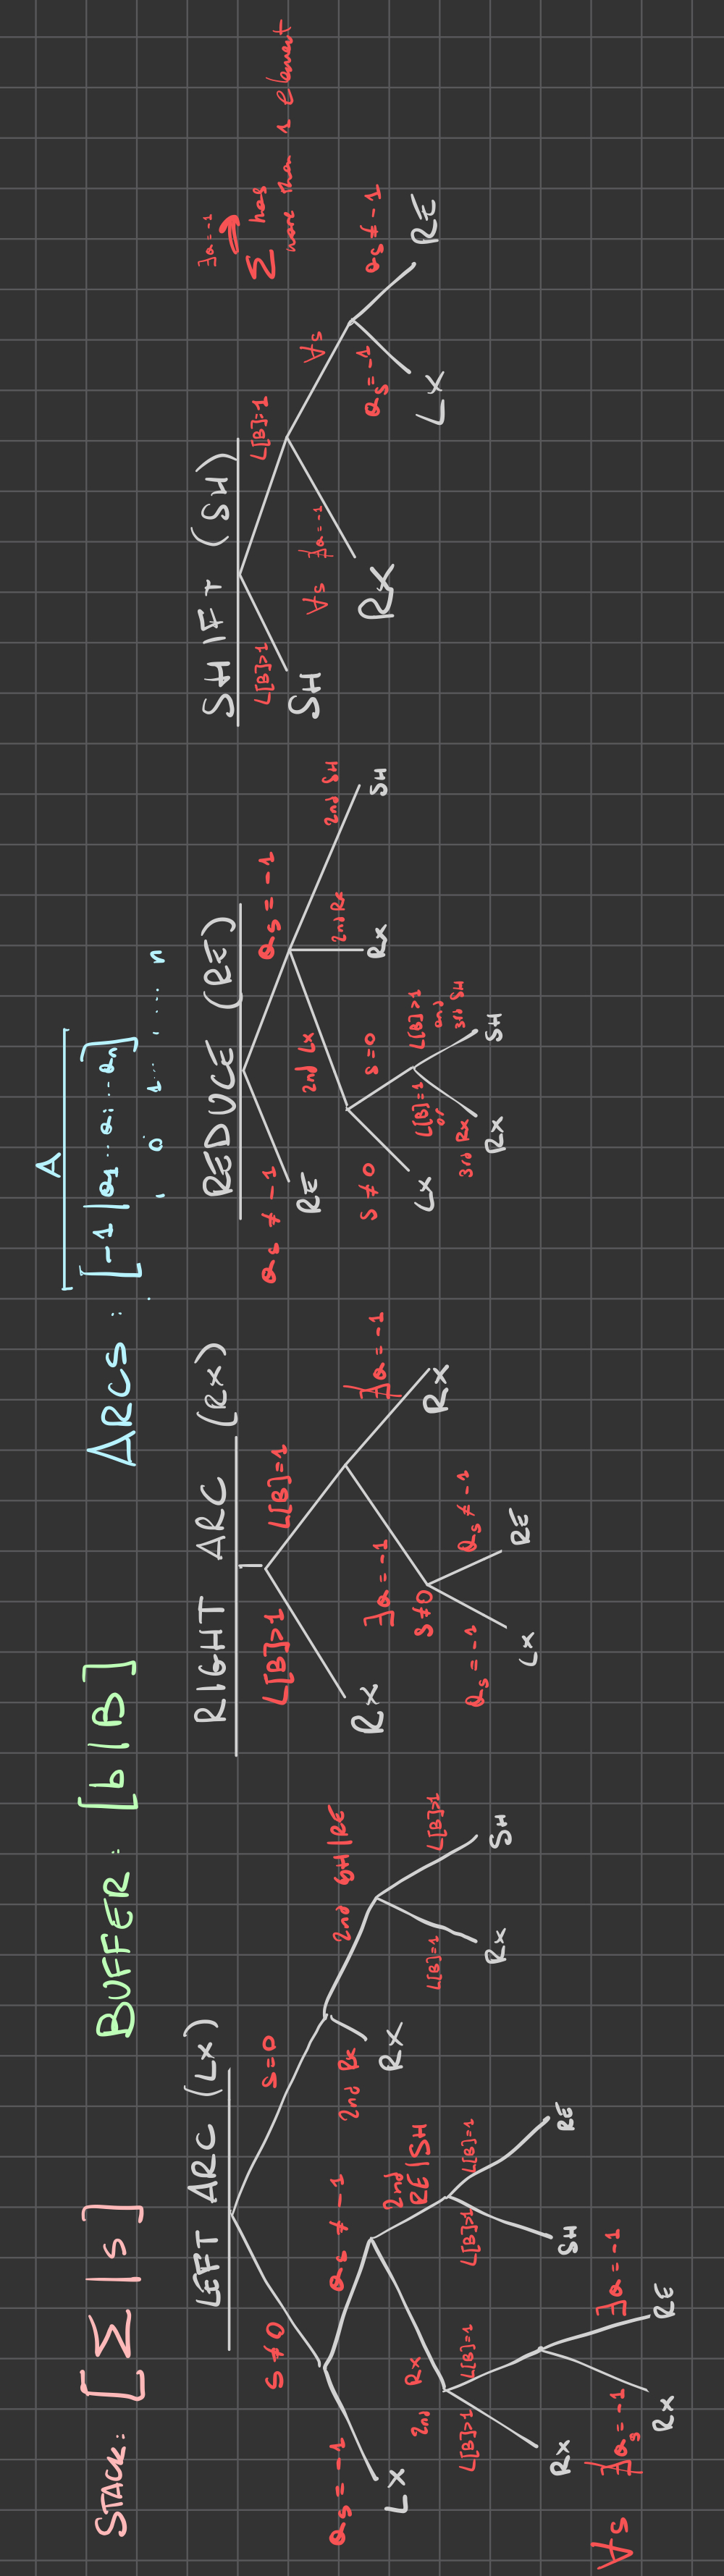

## Train and Test
Now that we have defined all our components, we are ready to train and test our model.


In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader, is_val = False):
  model.eval()

  total_loss = 0
  count = 0

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)
      gold += trees
      preds += pred

      if is_val:
         out = model(sentences, paths)
         labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array

         loss = criterion(out, labels)
         count +=1
         total_loss += loss.item()

         return evaluate(gold, preds), total_loss/count

      else:
         return evaluate(gold, preds)

This is our evaluation function. Remember that we use **UAS** (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.

In [ ]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

Finally, we run the training of our neural dependency parser.

In [ ]:
# "cuda" if torch.cuda.is_available() else
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net_eager(device)
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR) #provare con AdamW,
#scheduler = ExponentialLR(optimizer, gamma=0.9) #fa variare il learning rate mentre allena

Device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
bilstm_avg_train_loss = []
bilstm_val_loss = []
bilstm_val_uas = []

for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas, val_loss,  = test(model, val_dataloader, is_val = True)

  bilstm_avg_train_loss.append(avg_train_loss)
  bilstm_val_loss.append(val_loss)
  bilstm_val_uas.append(val_uas)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | avg_val_loss: {:5.3f} | dev_uas: {:5.3f} |".format(epoch, avg_train_loss, val_loss, val_uas))

Epoch:   0 | avg_train_loss: 1.087 | avg_val_loss: 0.989 | dev_uas: 0.478 |
Epoch:   1 | avg_train_loss: 0.913 | avg_val_loss: 0.921 | dev_uas: 0.589 |
Epoch:   2 | avg_train_loss: 0.877 | avg_val_loss: 0.885 | dev_uas: 0.666 |
Epoch:   3 | avg_train_loss: 0.857 | avg_val_loss: 0.857 | dev_uas: 0.740 |
Epoch:   4 | avg_train_loss: 0.842 | avg_val_loss: 0.841 | dev_uas: 0.776 |
Epoch:   5 | avg_train_loss: 0.832 | avg_val_loss: 0.831 | dev_uas: 0.763 |
Epoch:   6 | avg_train_loss: 0.823 | avg_val_loss: 0.818 | dev_uas: 0.784 |
Epoch:   7 | avg_train_loss: 0.816 | avg_val_loss: 0.808 | dev_uas: 0.820 |
Epoch:   8 | avg_train_loss: 0.810 | avg_val_loss: 0.801 | dev_uas: 0.833 |
Epoch:   9 | avg_train_loss: 0.805 | avg_val_loss: 0.797 | dev_uas: 0.825 |
Epoch:  10 | avg_train_loss: 0.802 | avg_val_loss: 0.792 | dev_uas: 0.830 |
Epoch:  11 | avg_train_loss: 0.797 | avg_val_loss: 0.791 | dev_uas: 0.841 |
Epoch:  12 | avg_train_loss: 0.794 | avg_val_loss: 0.789 | dev_uas: 0.846 |
Epoch:  13 |

In [ ]:
# Plot training history
def plot_history(bilstm_avg_train_loss, bilstm_val_loss, bilstm_val_uas):
   plt.figure(figsize=(16,4))
   plt.subplot(121)
   plt.title('Loss')
   plt.plot(bilstm_avg_train_loss, label='training_loss')
   plt.plot(bilstm_val_loss, label='validation_loss')
   plt.grid()
   plt.xlabel('Epoch')
   plt.ylabel('Loss')
   plt.legend()

   plt.subplot(122)
   plt.title('Val uas')
   plt.plot(bilstm_val_uas, label='val uas')
   #plt.plot(history.history['val_accuracy'], label='validation accuracy')
   plt.grid()
   plt.xlabel('Epoch')
   plt.ylabel('val uas')
   plt.legend()

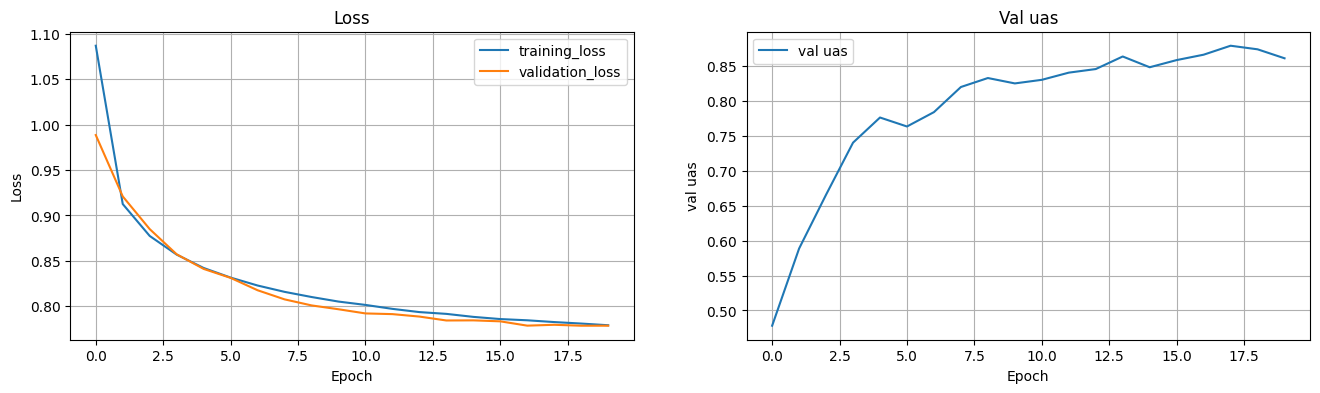

In [ ]:
plot_history(bilstm_avg_train_loss, bilstm_val_loss, bilstm_val_uas)

And finally we test on the test set.


In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas)) #0.60, 0.70 se tolgo le frasi non-projective

test_uas: 0.817


# **BERT**

**BERT** (bi-directional encoder representation from transformer) produces word representations by jointly conditioning on both left and right context. BERT can be used for downstream tasks, such as neural dependency parsing.

Since the corpus is in *latin* language, we have chose a multi-lingual based version of BERT (which was trained **ALSO** for latin), and Latin BERT. The procedure outlined the steps for utilizing the two pre-trained version of BERT for downstream tasks, such as neural dependency parsing and classification. Here's a breakdown of the steps:


1.   **Tokenization**: sentences in the training set have been tokenized using a tokenizer which breaks down each sentence into a sequence of subword token (each subword token has its own ID). Tokenization has been done inside the *prepare_batch* function. This allow us to perform dynamic padding, based on the longest sentence in the batch.
2.   **Special Tokens:** in order to indicate the beginning and separation of sentences, special tokens are added to each tokenized sentence. The [CLS] token represents the root, and the [SEP] token indicates the separation between sentences. Moreover, based on the longest sentence in the batch, [PAD] tokens have been considered, and consequently an attention mask which helps BERT to distinguish sentence tokens from [PAD] tokens;
3. **BERT input:** to summarize, for each batch, BERT receives as input the *input_ids_tensor* and the *attention mask*;
4. **BERT Embeddings:** As mentioned before, BERT is a bidirectional model that conditions on both left and right context, allowing it to capture rich contextual information. The model generates embeddings for each token in the input sentences.
5. **Average Pooling:** from the last layer of BERT, we have extracted the embeddings of each tokenized word. Remember that parser receive as input the original sentence (not the tokenized sentence). For that reason we have to take the average of word embeddings of each sub-tokenized word. This operation combines the contextual information captured by BERT for each sub-tokenized word.
6. **Classification:** the averaged word embeddings are then used as input features for dependency parsing using an arc-eager parser. By utilizing the sophisticated vector representations provided by BERT as input features, the hope is that the arc-eager parser can benefit from the rich contextual information captured by BERT, potentially improving the **UAS** compared to bi-LSTM word embeddings.



## **Download two models:**


*   multi-lingual BERT
*   latin BERT



In [ ]:
# Download models
multilingual_BERT = "bert-base-multilingual-cased"
tokenizer_multilingual_BERT = AutoTokenizer.from_pretrained(multilingual_BERT)

path_to_latin_bert = "./latin-bert-huggingface-main/bert-base-latin-uncased/"
tokenizer_latin_BERT = AutoTokenizer.from_pretrained(path_to_latin_bert)

## Average embedding function

This function performs the averaging of word embeddings obtained from the last hidden layer of BERT. Here's a brief explanation of how it works:

For each sentence in the batch:

  **a.** given a tokenized word, the function identifies the position $i$ of the first tokenized token corresponding to that word.

  **b.** it moves all the embeddings of that word to the position $i$ of the first tokenized token.

  **c.** it sums these embeddings and takes the average, resulting in the average embedding for that word. Simultaneously, in the positions where the embeddings were moved, we have zero tensors.

The function returns the **average embeddings** for each word in the batch, as well as a mask called **mask_subtoken**. This mask preserves the position of the first tokenized word, indicating where the average embedding is saved. It helps the model skip the zero tensors in subsequent operations, ensuring that only valid word embeddings are considered.

In [ ]:
#AVERAGE EMBEDDING FUNCTION

def average_embed(h, sentences_tokens_ids_tensors, tokenizer):

    consecutive_tokens = 1
    average_embeddings = torch.zeros_like(h)
    mask_subtoken = []

    for j in range(sentences_tokens_ids_tensors.shape[0]): #for each sentence in the batch

      sentence_ids = sentences_tokens_ids_tensors[j,:] #IDs average_embeddings of the sentence
      sentence = tokenizer.convert_ids_to_tokens(sentence_ids) #tokenized sentence
      mask_tokens = []
      for i,token in enumerate(sentence):
        if token.startswith("##"):
          average_embeddings[j, i-consecutive_tokens,:] = h[j, i-consecutive_tokens,:] + h[j, i,:]
          consecutive_tokens += 1

        elif not token.startswith("##") and consecutive_tokens > 1:
          average_embeddings[j, i-consecutive_tokens,:] = average_embeddings[j, i-consecutive_tokens,:]/consecutive_tokens
          average_embeddings[j, i,:] = h[j, i,:]
          consecutive_tokens = 1
          mask_tokens.append(i)

        else :
          average_embeddings[j,i, :] = h[j,i, :]
          mask_tokens.append(i)

      mask_subtoken.append(mask_tokens)
    return average_embeddings, mask_subtoken

## **Create training data and iterable dataloaders**

As done before, we process our data and create the actual training samples

In [ ]:
def preprocess_sample_BERT(sample, get_gold_path = False):

  sentence = ["ROOT"] + sample["tokens"]

  gold = [-1] + [int(i) for i in sample["head"]]

  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  gold_path = []
  gold_moves = []

  if get_gold_path:
    parser = ArcEager(sentence)
    oracle = EagerOracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)


      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()

      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)

      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(2)

      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)

  return enc_sentence, gold_path, gold_moves, gold #enc sentence quella del tokenizer

As done earlier, we batch the training data. But in addition to the previous steps, we incorporate the following enhancements

*   depending on whether the model is multilingual or Latin BERT, we tokenize the sentences within each batch accordingly;
*   to improve efficiency, we introduce **dynamic padding** within each batch. This means that instead of using fixed padding lengths for all sentences (the most length sentence), we dynamically adjust the padding length to match the longest sentence in the batch. This approach reduces unnecessary padding and further optimizes the training process.



In [ ]:
def prepare_batch_multilingual(batch_data, get_gold_path=False):

  data = [preprocess_sample_BERT(s, get_gold_path=get_gold_path) for s in batch_data]
  sent = [s["text"] for s in batch_data]

  tok = tokenizer_multilingual_BERT(sent, padding = True, return_tensors = 'pt')

  sentences_tokens_ids_tensors = tok["input_ids"].cuda()
  attention_mask_tensors = tok['attention_mask'].cuda()

  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]

  return sentences, sentences_tokens_ids_tensors, attention_mask_tensors, paths, moves, trees

In [ ]:
def prepare_batch_latin(batch_data, get_gold_path=False):

  data = [preprocess_sample_BERT(s, get_gold_path=get_gold_path) for s in batch_data]
  sent = [s["text"] for s in batch_data]

  tok = tokenizer_latin_BERT(sent, padding = True, return_tensors = 'pt')

  sentences_tokens_ids_tensors = tok["input_ids"].cuda()
  attention_mask_tensors = tok['attention_mask'].cuda()

  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]

  return sentences, sentences_tokens_ids_tensors, attention_mask_tensors, paths, moves, trees

## **Train and Test**
Now that we have defined all our components, we are ready to proceed with training and testing our model. These functions are identical for both BERT models, which is why they are defined at this point in the code.

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, sentences_tokens_ids_tensors, attention_mask_tensors, paths, moves, trees = batch

    out = model([sentences,sentences_tokens_ids_tensors, attention_mask_tensors], paths)
    labels = torch.tensor(sum(moves, [])).to(device)
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader, is_val = False):
  model.eval()
  total_loss = 0
  count = 0

  gold = []
  preds = []

  for batch in dataloader:
    sentences, sentences_tokens_ids_tensors, attention_mask_tensors, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere([sentences, sentences_tokens_ids_tensors, attention_mask_tensors])
      gold += trees
      preds += pred

      if is_val:
         out = model([sentences,sentences_tokens_ids_tensors, attention_mask_tensors], paths)
         labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array

         loss = criterion(out, labels)
         count +=1
         total_loss += loss.item()

         return evaluate(gold, preds), total_loss/count

      else:
         return evaluate(gold, preds)

________________________________________________________________________________
CREATE NEURAL NETWORK FOR THE TWO BERT MODELS
________________________________________________________________________________

In [ ]:
# BERT PARAMETERS (FOR BOTH MODELS (multilingual & latin))

BERT_SIZE = 768
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 20
LR = 5e-5

## **Multi-lingual BERT**

In [ ]:
# Create dataloader
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch_multilingual, get_gold_path=True))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_multilingual, get_gold_path=True))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_multilingual))

In [ ]:
class Net_eager_mBERT(nn.Module):

  def __init__(self, device):
    super(Net_eager_mBERT, self).__init__()
    self.device = device

    self.bert = AutoModel.from_pretrained(multilingual_BERT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(3*BERT_SIZE, MLP_SIZE, bias=True) # 1st fully-connected layer
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True) #2nd fully-connected layer
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT) #dropout

  #forward pass of the NN
  def forward(self, x, paths):
    h, mask = self.bert_pass([x[1], x[2]])
    mlp_input = self.get_mlp_input(paths, h, mask)

    out = self.mlp(mlp_input)

    return out

  def bert_pass(self, x):
    sentences_tokens_ids_tensors, attention_mask_tensors = x
    out = self.bert(sentences_tokens_ids_tensors, attention_mask_tensors) #input of BERT

    h = out.last_hidden_state #take the last hidden state (final embeddings)
    h, mask = average_embed(h, sentences_tokens_ids_tensors, tokenizer_multilingual_BERT) # apply average_emb function and obtain average embeddings and the mask
    h = h.permute(1,0,2)

    return h, mask

  def get_mlp_input(self, configurations, h, mask):
    mlp_input = []

    zero_tensor = torch.zeros(BERT_SIZE, requires_grad=False).to(self.device)

    for i in range(len(configurations)): # for every sentence in the batch
      h1 = [h[k] for k in mask[i]] # apply the mask

      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h1[j[0]][i], zero_tensor if j[1]==-1 else h1[j[1]][i], zero_tensor if j[2]==-1 else h1[j[2]][i]]))

    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x[0]]
    h, mask = self.bert_pass([x[1], x[2]])

    while not self.parsed_all(parsers):

      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h, mask)
      mlp_out = self.mlp(mlp_input)

      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[-1], parser.buffer[0]]
        if len(parser.stack) < 2:
          if len(parser.buffer) > 1:
            conf.append(parser.buffer[1])
          else:
            conf.append(-1)
        else:
          conf.insert(0,parser.stack[-2])
      configurations.append([conf])
    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    moves_topk = moves.topk(4).indices
    moves_second = moves_topk[:,1]

    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        #print(i)
        p = -1;
        if i == p:
          print(parsers[i].buffer)
          print(parsers[i].stack)
        if moves_argm[i] == 0:
          if parsers[i].stack[-1] != 0:
            if parsers[i].arcs[parsers[i].stack[-1]] == -1:
              parsers[i].left_arc()
              if i == p: print("llx0")
            else:
              if moves_second[i] == 1:
                if len(parsers[i].buffer) >1:
                  parsers[i].right_arc()
                  if i == p: print("lrx0")
                else:
                  if all(x != -1 for x in [parsers[i].arcs[ele] for ele in parsers[i].stack[1:]]):
                    parsers[i].right_arc()
                    if i == p: print("lrx1")
                  else:
                    parsers[i].reduce()
                    if i == p: print("lre0")
              elif moves_second[i] == 3:
                if len(parsers[i].buffer) >1:
                  parsers[i].shift()
                  if i == p: print("ls0")
                else:
                  parsers[i].reduce()
                  if i == p: print("lre01")
              else:
                parsers[i].reduce()
                if i == p: print("lre02")
          else:
            if moves_second[i] == 1:
              parsers[i].right_arc()
              if i == p: print("lrx2")

            elif moves_second[i] == 3:
              if len(parsers[i].buffer) <2:
                parsers[i].right_arc()
                if i == p: print("lrx3")
              else:
                parsers[i].shift()

            else:
              parsers[i].right_arc()
              if i == p: print("lrx04")

        elif moves_argm[i] == 1:
          if len(parsers[i].buffer) > 1:
            parsers[i].right_arc()
            if i == p: print("rrx1")
          else:
            if all(x != -1 for x in [parsers[i].arcs[ele] for ele in parsers[i].stack[1:]]):
              parsers[i].right_arc()
              if i == p: print("rrx2")
            else:
              if parsers[i].stack[-1] != 0:
                if parsers[i].arcs[parsers[i].stack[-1]] == -1:
                  parsers[i].left_arc()
                  if i == p: print("rlx1")
                else:
                  parsers[i].reduce()
                  if i == p: print("rre1")

        elif moves_argm[i] == 2:
          if parsers[i].arcs[parsers[i].stack[-1]] != -1:
            parsers[i].reduce()
            if i == p: print("re4")
          else:
            if moves_second[i] == 0:
              if parsers[i].stack[-1] != 0:
                parsers[i].left_arc()
                if i == p: print("lx2")
              else:
                if moves_topk[i,2] == 1 or len(parsers[i].buffer) < 2 :
                  parsers[i].right_arc()
                  if i == p: print("rx5")
                else:
                  parsers[i].shift()
                  if i == p: print("s2")
            elif moves_second[i] == 1:
              parsers[i].right_arc()
              if i == p: print("rx6")
            else:
              parsers[i].shift()
              if i == p: print("s3")

        elif moves_argm[i] == 3:
          if len(parsers[i].buffer) > 1:
            parsers[i].shift()
            if i == p: print("s4")
          else:
            if all(x != -1 for x in [parsers[i].arcs[ele] for ele in parsers[i].stack[1:]]):
                parsers[i].right_arc()
                if i == p: print("rx7")
            else:
              if parsers[i].arcs[parsers[i].stack[-1]] != -1:
                parsers[i].reduce()
                if i == p: print("re5")
              else:
                parsers[i].left_arc()
                if i == p: print("lx3")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net_eager_mBERT(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #provare con AdamW,
scheduler = ExponentialLR(optimizer, gamma=0.8) #fa variare il learning rate mentre allena

Device: cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
mBERT_avg_train_loss = []
mBERT_val_loss = []
mBERT_val_uas = []

for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  scheduler.step()
  val_uas, val_loss,  = test(model, val_dataloader, is_val = True)

  mBERT_val_loss.append(val_loss)
  mBERT_avg_train_loss.append(avg_train_loss)
  mBERT_val_uas.append(val_uas)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | avg_val_loss: {:5.3f} | dev_uas: {:5.3f} |".format(epoch, avg_train_loss, val_loss, val_uas))

Epoch:   0 | avg_train_loss: 0.917 | avg_val_loss: 0.811 | dev_uas: 0.811 |
Epoch:   1 | avg_train_loss: 0.806 | avg_val_loss: 0.786 | dev_uas: 0.854 |
Epoch:   2 | avg_train_loss: 0.788 | avg_val_loss: 0.778 | dev_uas: 0.873 |
Epoch:   3 | avg_train_loss: 0.779 | avg_val_loss: 0.771 | dev_uas: 0.897 |
Epoch:   4 | avg_train_loss: 0.774 | avg_val_loss: 0.768 | dev_uas: 0.902 |
Epoch:   5 | avg_train_loss: 0.770 | avg_val_loss: 0.763 | dev_uas: 0.895 |
Epoch:   6 | avg_train_loss: 0.768 | avg_val_loss: 0.765 | dev_uas: 0.909 |
Epoch:   7 | avg_train_loss: 0.766 | avg_val_loss: 0.764 | dev_uas: 0.900 |
Epoch:   8 | avg_train_loss: 0.763 | avg_val_loss: 0.763 | dev_uas: 0.901 |
Epoch:   9 | avg_train_loss: 0.762 | avg_val_loss: 0.761 | dev_uas: 0.906 |
Epoch:  10 | avg_train_loss: 0.761 | avg_val_loss: 0.762 | dev_uas: 0.904 |
Epoch:  11 | avg_train_loss: 0.760 | avg_val_loss: 0.760 | dev_uas: 0.909 |
Epoch:  12 | avg_train_loss: 0.759 | avg_val_loss: 0.760 | dev_uas: 0.910 |
Epoch:  13 |

### **Learning curves**

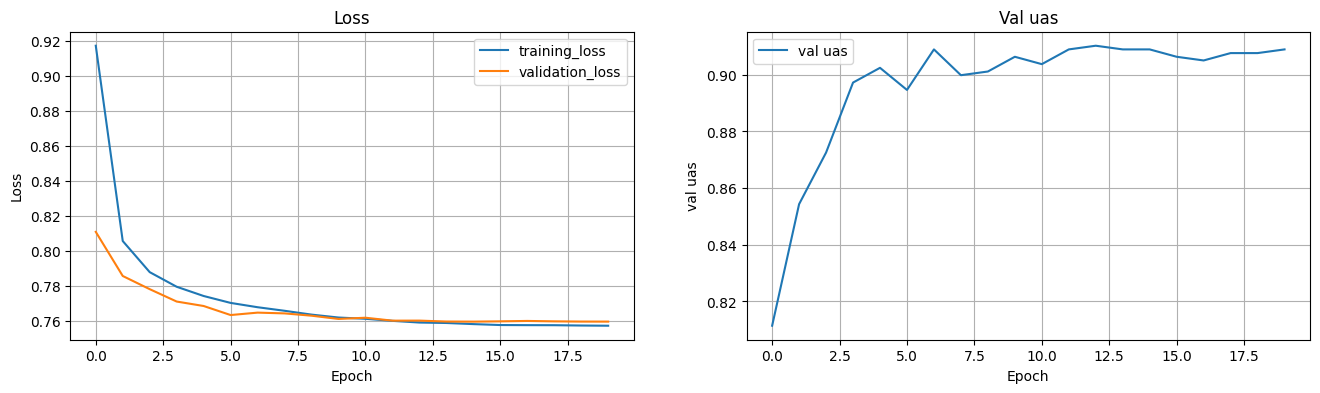

In [ ]:
plot_history(mBERT_avg_train_loss,mBERT_val_loss,mBERT_val_uas)

### **Evaluation**

In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.897


## **Latin BERT**

In [ ]:
# Create dataloader
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch_latin, get_gold_path=True))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_latin, get_gold_path=True))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_latin))

In [ ]:
class Net_eager_latinBERT(nn.Module):

  def __init__(self, device):
    super(Net_eager_latinBERT, self).__init__()
    self.device = device

    self.bert = AutoModel.from_pretrained(path_to_latin_bert)

    # initialize feedforward
    self.w1 = torch.nn.Linear(3*BERT_SIZE, MLP_SIZE, bias=True) # 1st fully-connected layer
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True) #2nd fully-connected layer
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT) #dropout

  #forward pass of the NN
  def forward(self, x, paths):
    h, mask = self.bert_pass([x[1], x[2]])
    mlp_input = self.get_mlp_input(paths, h, mask)

    out = self.mlp(mlp_input)

    return out

  def bert_pass(self, x):
    sentences_tokens_ids_tensors, attention_mask_tensors = x
    out = self.bert(sentences_tokens_ids_tensors, attention_mask_tensors) #input of BERT

    h = out.last_hidden_state #take the last hidden state (final embeddings)
    h, mask = average_embed(h, sentences_tokens_ids_tensors, tokenizer_latin_BERT) # apply average_emb function and obtain average embeddings and the mask
    h = h.permute(1,0,2)

    return h, mask

  def get_mlp_input(self, configurations, h, mask):
    mlp_input = []

    zero_tensor = torch.zeros(BERT_SIZE, requires_grad=False).to(self.device)

    for i in range(len(configurations)): # for every sentence in the batch
      h1 = [h[k] for k in mask[i]] #apply the mask

      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h1[j[0]][i], zero_tensor if j[1]==-1 else h1[j[1]][i], zero_tensor if j[2]==-1 else h1[j[2]][i]]))

    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x[0]]
    h, mask = self.bert_pass([x[1], x[2]])

    while not self.parsed_all(parsers):

      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h, mask)
      mlp_out = self.mlp(mlp_input)

      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[-1], parser.buffer[0]]
        if len(parser.stack) < 2:
          if len(parser.buffer) > 1:
            conf.append(parser.buffer[1])
          else:
            conf.append(-1)
        else:
          conf.insert(0,parser.stack[-2])
      configurations.append([conf])
    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implementwe didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly

  these checks in the parser so we must do them here. This renders the function quite ugly

  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    moves_topk = moves.topk(4).indices
    moves_second = moves_topk[:,1]

    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        p = -1;
        if i == p:
          print(parsers[i].buffer)
          print(parsers[i].stack)
        if moves_argm[i] == 0:
          if parsers[i].stack[-1] != 0:
            if parsers[i].arcs[parsers[i].stack[-1]] == -1:
              parsers[i].left_arc()
              if i == p: print("llx0")
            else:
              if moves_second[i] == 1:
                if len(parsers[i].buffer) >1:
                  parsers[i].right_arc()
                  if i == p: print("lrx0")
                else:
                  if all(x != -1 for x in [parsers[i].arcs[ele] for ele in parsers[i].stack[1:]]):
                    parsers[i].right_arc()
                    if i == p: print("lrx1")
                  else:
                    parsers[i].reduce()
                    if i == p: print("lre0")
              elif moves_second[i] == 3:
                if len(parsers[i].buffer) >1:
                  parsers[i].shift()
                  if i == p: print("ls0")
                else:
                  parsers[i].reduce()
                  if i == p: print("lre01")
              else:
                parsers[i].reduce()
                if i == p: print("lre02")
          else:
            if moves_second[i] == 1:
              parsers[i].right_arc()
              if i == p: print("lrx2")

            elif moves_second[i] == 3:
              if len(parsers[i].buffer) <2:
                parsers[i].right_arc()
                if i == p: print("lrx3")
              else:
                parsers[i].shift()

            else:
              parsers[i].right_arc()
              if i == p: print("lrx04")

        elif moves_argm[i] == 1:
          if len(parsers[i].buffer) > 1:
            parsers[i].right_arc()
            if i == p: print("rrx1")
          else:
            if all(x != -1 for x in [parsers[i].arcs[ele] for ele in parsers[i].stack[1:]]):
              parsers[i].right_arc()
              if i == p: print("rrx2")
            else:
              if parsers[i].stack[-1] != 0:
                if parsers[i].arcs[parsers[i].stack[-1]] == -1:
                  parsers[i].left_arc()
                  if i == p: print("rlx1")
                else:
                  parsers[i].reduce()
                  if i == p: print("rre1")

        elif moves_argm[i] == 2:
          if parsers[i].arcs[parsers[i].stack[-1]] != -1:
            parsers[i].reduce()
            if i == p: print("re4")
          else:
            if moves_second[i] == 0:
              if parsers[i].stack[-1] != 0:
                parsers[i].left_arc()
                if i == p: print("lx2")
              else:
                if moves_topk[i,2] == 1 or len(parsers[i].buffer) < 2 :
                  parsers[i].right_arc()
                  if i == p: print("rx5")
                else:
                  parsers[i].shift()
                  if i == p: print("s2")
            elif moves_second[i] == 1:
              parsers[i].right_arc()
              if i == p: print("rx6")
            else:
              parsers[i].shift()
              if i == p: print("s3")

        elif moves_argm[i] == 3:
          if len(parsers[i].buffer) > 1:
            parsers[i].shift()
            if i == p: print("s4")
          else:
            if all(x != -1 for x in [parsers[i].arcs[ele] for ele in parsers[i].stack[1:]]):
                parsers[i].right_arc()
                if i == p: print("rx7")
            else:
              if parsers[i].arcs[parsers[i].stack[-1]] != -1:
                parsers[i].reduce()
                if i == p: print("re5")
              else:
                parsers[i].left_arc()
                if i == p: print("lx3")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net_eager_latinBERT(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #provare con AdamW,
scheduler = ExponentialLR(optimizer, gamma=0.8) #fa variare il learning rate mentre allena

Device: cuda


Some weights of the model checkpoint at ./latin-bert-huggingface-main/bert-base-latin-uncased/ were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
latinBERT_avg_train_loss = []
latinBERT_val_loss = []
latinBERT_val_uas = []

for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  scheduler.step()
  val_uas, val_loss,  = test(model, val_dataloader, is_val = True)

  latinBERT_val_loss.append(val_loss)
  latinBERT_avg_train_loss.append(avg_train_loss)
  latinBERT_val_uas.append(val_uas)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | avg_val_loss: {:5.3f} | dev_uas: {:5.3f} |".format(epoch, avg_train_loss, val_loss, val_uas))

Epoch:   0 | avg_train_loss: 0.915 | avg_val_loss: 0.803 | dev_uas: 0.821 |
Epoch:   1 | avg_train_loss: 0.805 | avg_val_loss: 0.781 | dev_uas: 0.865 |
Epoch:   2 | avg_train_loss: 0.788 | avg_val_loss: 0.772 | dev_uas: 0.884 |
Epoch:   3 | avg_train_loss: 0.781 | avg_val_loss: 0.771 | dev_uas: 0.897 |
Epoch:   4 | avg_train_loss: 0.776 | avg_val_loss: 0.770 | dev_uas: 0.892 |
Epoch:   5 | avg_train_loss: 0.773 | avg_val_loss: 0.768 | dev_uas: 0.901 |
Epoch:   6 | avg_train_loss: 0.770 | avg_val_loss: 0.768 | dev_uas: 0.902 |
Epoch:   7 | avg_train_loss: 0.768 | avg_val_loss: 0.765 | dev_uas: 0.904 |
Epoch:   8 | avg_train_loss: 0.767 | avg_val_loss: 0.765 | dev_uas: 0.906 |
Epoch:   9 | avg_train_loss: 0.766 | avg_val_loss: 0.766 | dev_uas: 0.902 |
Epoch:  10 | avg_train_loss: 0.765 | avg_val_loss: 0.765 | dev_uas: 0.902 |
Epoch:  11 | avg_train_loss: 0.764 | avg_val_loss: 0.764 | dev_uas: 0.905 |
Epoch:  12 | avg_train_loss: 0.763 | avg_val_loss: 0.764 | dev_uas: 0.908 |
Epoch:  13 |

### **Learning curves**

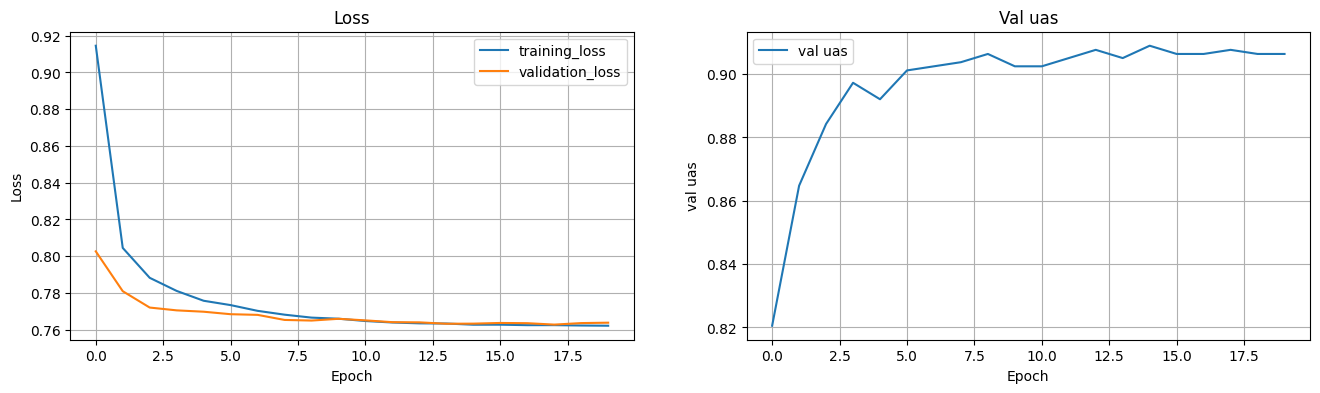

In [ ]:
plot_history(latinBERT_avg_train_loss,latinBERT_val_loss,latinBERT_val_uas)

### **Evaluation**

In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.885


# **Models comparison**

In [ ]:
# Plot training history
def plot_history_comparison(bilstm_avg_train_loss, bilstm_val_loss, bilstm_val_uas, mBERT_avg_train_loss, mBERT_val_loss, mBERT_val_uas, latinBERT_avg_train_loss, latinBERT_loss, latinBERT_val_uas):
   plt.figure(figsize=(16,4))
   plt.subplot(131)
   plt.title('Training loss comparison')
   plt.plot(bilstm_avg_train_loss, label='training loss bi_LSTM')
   plt.plot(mBERT_avg_train_loss, label='training loss mBERT')
   plt.plot(latinBERT_avg_train_loss, label='training loss latin BERT')
   plt.grid()
   plt.xlabel('Epoch')
   plt.ylabel('Training Loss')
   plt.legend()

   plt.subplot(132)
   plt.title('Validation loss comparison')
   plt.plot(bilstm_val_loss, label='validation loss bi_LSTM')
   plt.plot(mBERT_val_loss, label='validation loss mbert')
   plt.plot(latinBERT_val_loss, label='validation loss latin BERT')
   plt.grid()
   plt.xlabel('Epoch')
   plt.ylabel('Loss')
   plt.legend()

   plt.subplot(133)
   plt.title('UAS comparison')
   plt.plot(bilstm_val_uas, label='bi-LSTM UAS')
   plt.plot(mBERT_val_uas, label='mBERT UAS')
   plt.plot(latinBERT_val_uas, label='latinBERT UAS')
   plt.grid()
   plt.xlabel('Epoch')
   plt.ylabel('UAS')
   plt.legend()

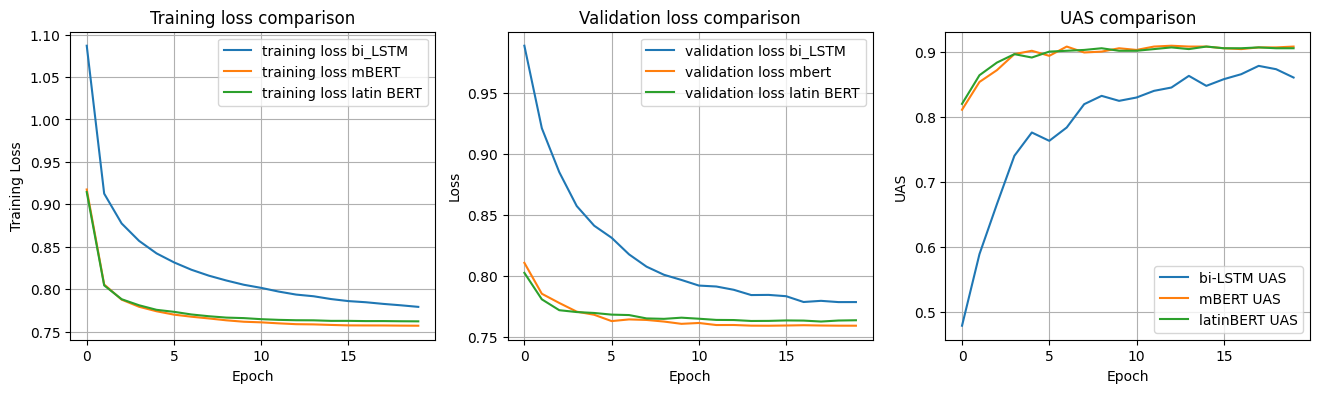

In [ ]:
# Models comparison
plot_history_comparison(bilstm_avg_train_loss, bilstm_val_loss, bilstm_val_uas, mBERT_avg_train_loss, mBERT_val_loss, mBERT_val_uas, latinBERT_avg_train_loss, latinBERT_val_loss, latinBERT_val_uas)

# **Results**
The training curves for all three proposed models indicate the absence of overfitting, while it is clearly observable that achieving a lower loss value corresponds to obtaining a higher UAS score.

- During the training step, for bi-LSTM, the UAS stabilizes after approximately **15-20 epochs** at an average value of **$0.86$**. On the other hand, both mBERT and LatinBERT reach a stable UAS value much earlier, starting from a significantly lower loss. Both mBERT and LatinBERT achieve an average UAS value of $0.91$.
-  The quick convergence to a stable value after a few epochs of multilingual and latin BERT can be attributed to the dataset being large and highly redundant and to the high model complexity. The model quickly learns the majority of the dataset's features, and then slightly overfits as it fine-tunes its performance. Without exposure to novel samples or additional information, the model may not learn anything new about the underlying properties of the classes, resulting in limited improvement in accuracy beyond the initial stages of training.

- As expected, the comprehensive contextual information captured by BERT has resulted in a higher Unlabeled Attachment Score (UAS) compared to the bi-LSTM neural network ($0.82$ vs. $ \approx 0.9$). This demonstrates the superiority of BERT in leveraging contextual embeddings for improved dependency parsing performance.
- The UAS value for both mBERT and LatinBERT in the test step remains stable, averaging at **$\approx 0.9$**. This indicates that the models have learned the relevant patterns and dependencies from the training data and are able to generalize well to unseen test data, achieving consistent performance.


#**Comparison with the SoTA & Conclusions**


*   Since the Late Latin Charter Treebank dataset has been added to the *HuggingFace Universal Dependecie*s quite recently, in v2.10, there are few papers reporting results on dependency parsing, relative to this dataset. In $[1]$, by analyzing discrepancies among five different Latin datasets, a harmonization of these datasets is proposed to showcase potential improvements in UAS score for the dependency parsing task. The paper utilizes **UDPipe** and **Stanza models**, incorporating FastText for word embedding.
The results they obtained for this task are comparable to the benchmarks reported on the UDPipe and Stanza websites;

*   According to the referenced paper, the state-of-the-art performance for the UD_LLCT dataset, as reported, stands at a UAS value of **$93.88\%$** for **UDPipe** and $95.81\%$ for **Stanza**;


*   Our results are **in line** with the state of the art, albeit slightly lower than the benchmark for the task. Although one would expect an improvement in UAS performance using LatinBERT, the two models show quite similar performance. The reason for this result can probably be attributed to the fact that the data used for training the multilingual model are more similar to the dataset used in this project, while the LatinBERT training data may refer to more classical Latin datasets and therefore slightly different.. However, an advantage of using LatinBERT is the increased training speed, which reduces the waiting time by $40\%$.

#**References**

[1] *Gamba, Federica, and Daniel Zeman. "Universalising Latin Universal Dependencies: a harmonisation of Latin treebanks in UD." _Proceedings of the Sixth Workshop on Universal Dependencies (UDW, GURT/SyntaxFest 2023)_. 2023.*

[2] *Nehrdich, Sebastian, and Oliver Hellwig. "Accurate Dependency Parsing and Tagging of Latin." Proceedings of the Second Workshop on Language Technologies for Historical and Ancient Languages. 2022.*

[3] https://universaldependencies.org/treebanks/la_llct/index.html;

[4] https://ufal.mff.cuni.cz/udpipe/2/models#universal_dependencies_210_models;

[5] https://stanfordnlp.github.io/stanza/performance.html;